<a href="https://colab.research.google.com/github/SlmaKh/-div-elopers/blob/master/Bi_directional_LSTM_15_08_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense
from tensorflow.keras.preprocessing import sequence
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM 
from keras.layers import Embedding, Activation, Dense, Dropout, Input, Concatenate
import tensorflow as tf


In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
def plot_confusion_matrix(matrix, title):
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
  plt.title('Confusion matrix for ' +title)

In [4]:
!pip install tensorflow_addons

     |████████████████████████████████| 679 kB 5.3 MB/s 


In [5]:
test = pd.read_csv("drive/MyDrive/Colab Notebooks/Bachelor Thesis/test_prepared.csv")
train = pd.read_csv("drive/MyDrive/Colab Notebooks/Bachelor Thesis/train_subset.csv")

In [6]:
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

#**Tokenize the data**

In [7]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)


In [8]:
word_index = tokenizer.word_index

In [9]:
maxlen = 200
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

In [10]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]


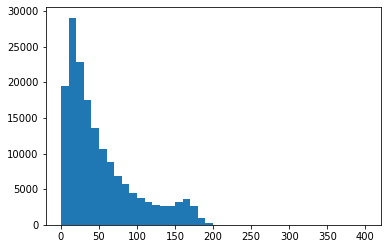

In [11]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

#**Model for all labels**

In [12]:
from keras.models import Model

inp = Input(shape=(maxlen, ))
x = Embedding(len(word_index) + 1,
              300,
              input_length = maxlen,
              name = 'embeddings')(inp)
x = Bidirectional(LSTM(50, return_sequences=True,name='lstm_layer'))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)
model_all_labels = Model(inputs=inp, outputs=x)
model_all_labels.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [13]:
list_classes = ["toxic", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]
y_train_all_labels = train[list_classes].values
y_test_all_labels = test[list_classes].values

In [14]:
batch_size = 32
epochs = 2
model_all_labels.fit(X_t,y_train_all_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4634/4634 [==============================] - 2796s 598ms/step - loss: 0.2065 - accuracy: 0.9272 - val_loss: 0.1266 - val_accuracy: 0.9959
Epoch 2/2
4634/4634 [==============================] - 2772s 598ms/step - loss: 0.1191 - accuracy: 0.9777 - val_loss: 0.1214 - val_accuracy: 0.9933


##Prediction

In [15]:
X_te.shape

(97320, 200)

In [16]:
model_all_labels_test_prediction = model_all_labels.predict(X_te)

##Model evaluation

In [29]:
import copy
def convert_to_binary1(predictions):
  temp = copy.deepcopy(predictions)
  temp[temp>=0.8] = 1
  temp[temp<0.8] = 0
  return temp

In [30]:
model_all_label_test_predictions_binary = convert_to_binary1(model_all_labels_test_prediction)

In [31]:
print("Test all label Accuracy = ",accuracy_score(y_test_all_labels,model_all_label_test_predictions_binary))
print("Test all label f1 score micro ", f1_score(y_test_all_labels, model_all_label_test_predictions_binary, average = 'micro'))
print("Test all label f1 score  macro", f1_score(y_test_all_labels, model_all_label_test_predictions_binary, average = 'macro'))

print("Test all label AUC is micro ", roc_auc_score(y_test_all_labels, model_all_labels_test_prediction, average = 'micro'))
# print("Test multilabel AUC is macro ", roc_auc_score(y_test_multilabel, test_predictions_multilabel5_binary, average = 'macro'))

print("The all label test precision micro is ", precision_score(y_test_all_labels, model_all_label_test_predictions_binary, average = 'micro'))
print("The all label test precision macro is ", precision_score(y_test_all_labels, model_all_label_test_predictions_binary, average = 'macro'))

print("The all label test recall micro is ", recall_score(y_test_all_labels, model_all_label_test_predictions_binary, average = 'micro'))
print("The all label test recall macro is ", recall_score(y_test_all_labels, model_all_label_test_predictions_binary, average = 'macro'))


Test all label Accuracy =  0.845242498972462
Test all label f1 score micro  0.4831999065038275
Test all label f1 score  macro 0.30789259265060126


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Test all label AUC is micro  0.9653936395722233
The all label test precision micro is  0.42683115676456923
The all label test precision macro is  0.424786680940763
The all label test recall micro is  0.5567225476334747
The all label test recall macro is  0.3039611102189876


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
confusion_matrix_all_label = multilabel_confusion_matrix(y_test_all_labels, model_all_label_test_predictions_binary)
confusion_matrix_all_label

array([[[79417, 10232],
        [ 1981,  5690]],

       [[97320,     0],
        [    0,     0]],

       [[96688,   107],
        [  324,   201]],

       [[97085,    11],
        [  218,     6]],

       [[91213,   338],
        [ 3593,  2176]],

       [[96240,   416],
        [  468,   196]]])

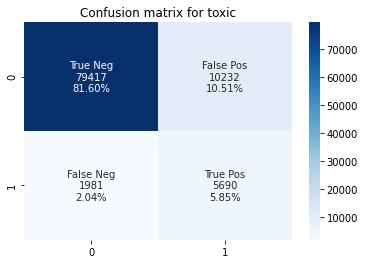

In [33]:
plot_confusion_matrix(confusion_matrix_all_label[0], "toxic")

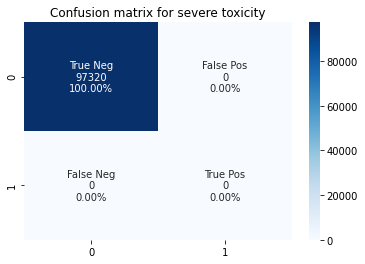

In [34]:
plot_confusion_matrix(confusion_matrix_all_label[1], "severe toxicity")

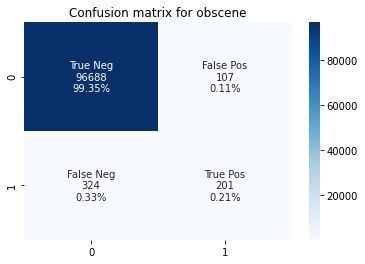

In [35]:
plot_confusion_matrix(confusion_matrix_all_label[2], "obscene")

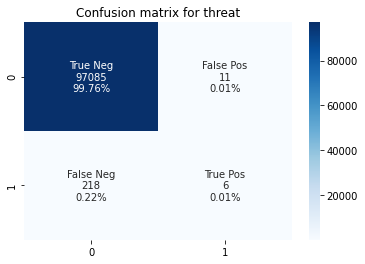

In [36]:
plot_confusion_matrix(confusion_matrix_all_label[3], "threat")

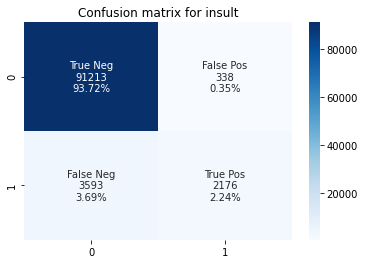

In [37]:
plot_confusion_matrix(confusion_matrix_all_label[4], "insult")

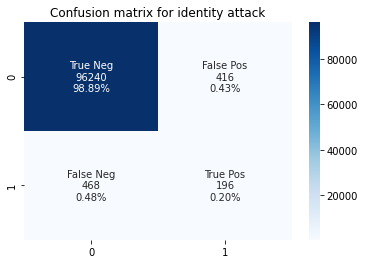

In [38]:
plot_confusion_matrix(confusion_matrix_all_label[5], "identity attack")